### iid

### 准备各个用户数据

In [ ]:
# 挂载谷歌云盘
from google.colab import drive
drive.mount("/content/drive")

# 准备各个用户数据
import pandas as pd

good_user_number=10



all_user_data=[]
all_user_label=[]
all_user_validate_data=[]
all_user_validate_label=[]

for i in range(good_user_number):
  all_user_data.append(pd.read_csv("/content/drive/MyDrive/EE_blockchain/iid/u"+str(i)+"/data.csv",index_col=0).values)
  all_user_label.append(pd.read_csv("/content/drive/MyDrive/EE_blockchain/iid/u"+str(i)+"/label.csv",index_col=0).values)

requester_data=pd.read_csv("/content/drive/MyDrive/EE_blockchain/non_iid/requester/data.csv",index_col=0).values
requester_label=pd.read_csv("/content/drive/MyDrive/EE_blockchain/non_iid/requester/label.csv",index_col=0).values

validate_data=pd.read_csv("/content/drive/MyDrive/EE_blockchain/non_iid/validate/data.csv",index_col=0).values
validate_label=pd.read_csv("/content/drive/MyDrive/EE_blockchain/non_iid/validate/label.csv",index_col=0).values

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 定义函数

In [ ]:
%tensorflow_version 1.x
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()
# tf.reset_default_graph()
# tf.set_random_seed(2)

class FL:
    def __init__(self,name,sess,data=None,label=None,isCommittee=False,isBad=False,lr=0.0005):
        self.lr=lr    #LEARNING_RATE
        self.sess=sess
        self.name=name
        self.c_name=self.name+"params"
        self.parameters=self.build_net(self.c_name)
        self.data=data
        self.label=label
        self.isCommittee=isCommittee
        self.isBad=isBad
        
        
        
    def build_net(self,c_name):
        CONV_SIZE = 3
        CONV_1_KERNAL = 32 
        CONV_2_KERNAL = 64
        
        W_INITIALIZER=tf.truncated_normal_initializer(0,0.05)
        B_INITIALIZER=tf.constant_initializer(0.03)

                    
        # 卷积神经网络
        def params(name,shape,initializer,c_names):
            return tf.get_variable(name,shape,initializer=initializer,collections=c_names)
        
        def conv2d(x,w):
            return tf.nn.conv2d(x,w,strides=[1,1,1,1],padding="SAME")
        
        def pool(x):
            return tf.nn.max_pool(x,ksize=[1,2,2,1],strides=[1,2,2,1],padding="SAME")
        
        self.x=tf.placeholder(tf.float32,[None,784],name="input_features")
        self.y=tf.placeholder(tf.float32,[None,10],name="actual_labels")
        self.keep_prob=tf.placeholder(tf.float32,name="keep_prob")
        image_x=tf.reshape(self.x,[-1,28,28,1])
        
        c_names=[tf.GraphKeys.GLOBAL_VARIABLES,c_name]
        with tf.variable_scope("conv_1"):
            conv_1_w=params("conv_1_w",[CONV_SIZE,CONV_SIZE,1,CONV_1_KERNAL],W_INITIALIZER,c_names)
            conv_1_b=params("conv_1_b",CONV_1_KERNAL,B_INITIALIZER,c_names)
            conv_1_out=tf.nn.relu(conv2d(image_x,conv_1_w)+conv_1_b)
            l1=tf.nn.dropout(pool(conv_1_out),self.keep_prob)
        
        
        with tf.variable_scope("conv_2"):
            conv_2_w=params("conv_2_w",[CONV_SIZE,CONV_SIZE,CONV_1_KERNAL,CONV_2_KERNAL],W_INITIALIZER,c_names)
            conv_2_b=params("conv_2_b",CONV_2_KERNAL,B_INITIALIZER,c_names)
            conv_2_out=tf.nn.relu(conv2d(l1,conv_2_w)+conv_2_b)
            l2=tf.nn.dropout(pool(conv_2_out),self.keep_prob)
        
        with tf.variable_scope("fc_1"):
            flattened_input=tf.reshape(l2,[-1,7*7*CONV_2_KERNAL])
            fc_1_w=params("fc_1_w",[7*7*CONV_2_KERNAL,512],W_INITIALIZER,c_names)
            fc_1_b=params("fc_1_b",512,B_INITIALIZER,c_names)
            l4=tf.nn.dropout(tf.nn.relu(tf.matmul(flattened_input,fc_1_w)+fc_1_b),self.keep_prob)
            
        with tf.variable_scope("fc_2"):
            fc_2_w=params("fc_2_w",[512,10],W_INITIALIZER,c_names)
            fc_2_b=params("fc_2_b",10,B_INITIALIZER,c_names)
            output=tf.nn.softmax(tf.matmul(l4,fc_2_w)+fc_2_b)  
        
             
        
        with tf.variable_scope("loss"):
            self.loss=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.y,logits=output))
            
        with tf.variable_scope("accuracy"):
            self.accuracy=tf.reduce_mean(tf.cast(tf.equal(tf.argmax(self.y,axis=1),tf.argmax(output,axis=1)),tf.float32))
            
        with tf.variable_scope("train"):
            self.train_op=tf.train.RMSPropOptimizer(self.lr).minimize(self.loss)
        
        return tf.get_collection(c_name)

    def train(self):
        batch_size=100
        n_batch=int(self.data.shape[0]/batch_size) 
        for i in range(n_batch):
            self.sess.run(self.train_op,feed_dict={self.x:self.data[i*batch_size:(i+1)*batch_size],
                  self.y:self.label[i*batch_size:(i+1)*batch_size],
                  self.keep_prob:1.0})
          
    
    def validate(self,data,label):
        batch_size=100
        n_batch=int(data.shape[0]/batch_size)
        acc=0
        for i in range(n_batch):
          x=self.sess.run(self.accuracy,feed_dict={self.x:data[i*batch_size:(i+1)*batch_size],
                              self.y:label[i*batch_size:(i+1)*batch_size],
                              self.keep_prob:1.0})
          acc+=(x/n_batch)
        return acc



def broadcast(all_user_FL,global_FL):
  global_model_broadcast=[]
  for user_FL in all_user_FL:
    global_model_broadcast+=[tf.assign(e,t) for e,t in zip(user_FL.parameters,global_FL.parameters)]
  global_sess.run(global_model_broadcast)

def committee_validate(committee_FL,all_user_FL):
  all_user_FL_scores=[]
  if committee_FL.isBad==False:
    for user_FL in all_user_FL:
      all_user_FL_scores.append(user_FL.validate(committee_FL.data,committee_FL.label))
  else:
    for user_FL in all_user_FL:
      if user_FL.isBad==True:
        all_user_FL_scores.append(1.0)
      else:
        all_user_FL_scores.append(0.0)
  print(all_user_FL_scores)
  return all_user_FL_scores

tao=0.05

def get_next_global_model_and_commmittee_users(all_user_FL,global_model,all_user_FL_scores,global_model_score):
  global_sess.run([tf.assign(t,0*e) for t,e in zip(global_model.parameters,global_model.parameters)])
  k=0
  for i in range(all_user_number):
    all_user_FL[i].isCommittee=False
    score=all_user_FL_scores[i]
    if(score>global_model_score):
      k=k+1
      all_user_FL[i].isCommittee=True
      global_sess.run([tf.assign(t,e+t) for t,e in zip(global_model.parameters,all_user_FL[i].parameters)])
  if k!=0:
    global_sess.run([tf.assign(t,e/k) for t,e in zip(global_model.parameters,global_model.parameters)])
  else:
    for i in range(all_user_number):
      all_user_FL[i].isCommittee=False
      score=all_user_FL_scores[i]
      if(score>global_model_score*(1-tao)):
        k=k+1
        all_user_FL[i].isCommittee=True
        global_sess.run([tf.assign(t,e+t) for t,e in zip(global_model.parameters,all_user_FL[i].parameters)])
    if k!=0:
      global_sess.run([tf.assign(t,e/k) for t,e in zip(global_model.parameters,global_model.parameters)])
    else:
      for i in range(all_user_number):
        all_user_FL[i].isCommittee=True
        global_sess.run([tf.assign(t,e+t) for t,e in zip(global_model.parameters,all_user_FL[i].parameters)])
      global_sess.run([tf.assign(t,e/all_user_number) for t,e in zip(global_model.parameters,global_model.parameters)])
  isCommittee=[0 for i in range(all_user_number)]
  for i in range(all_user_number):
    if(all_user_FL[i].isCommittee==True):
      isCommittee[i]=1
  print(isCommittee)

def local_train(all_user_FL):
  for user_FL in all_user_FL:
    if user_FL.isBad==False:
      user_FL.train()
    else:
      # 恶意提供坏模型—1
      global_sess.run([tf.assign(t,0*e) for  t,e in zip(user_FL.parameters,user_FL.parameters)])
      # 恶意提供坏模型—2
      # global_sess.run([tf.assign(t,e-0.1*e) for  t,e in zip(user_FL.parameters,user_FL.parameters)])
      # 恶意不训练
      # global_sess.run([tf.assign(t,e) for  t,e in zip(user_FL.parameters,user_FL.parameters)])
    print(global_sess.run(user_FL.parameters)[2][2][0][0][:5])

def get_global_model_score(all_user_FL,global_model):
  global_model_score=[]
  for user_FL in all_user_FL:
    if user_FL.isCommittee==True:
      if user_FL.isBad==False:
        global_model_score.append(global_model.validate(user_FL.data,user_FL.label))
      else:
        global_model_score.append(0.999999)
  print("处理前 global_model_score: "+str(global_model_score))
  delta=np.std(global_model_score)
  mean=np.mean(global_model_score)
  for i in range(len(global_model_score)-1,-1,-1):
    x=global_model_score[i]
    if x<mean-delta or x>mean+delta:
      global_model_score.remove(x)
  print("处理后 global_model_score: "+str(global_model_score))
  print("global_model_score: "+str(np.mean(global_model_score)))
  return np.mean(global_model_score)


def get_all_user_FL_scores(all_user_FL):
  print("处理前 all_user_FL_scores")
  committee_to_all_user_FL_scores=[]
  for user_FL in all_user_FL:
    if user_FL.isCommittee==True:
      print(user_FL.name)
      committee_to_all_user_FL_scores.append(committee_validate(user_FL,all_user_FL))
  all_user_FL_scores=[]
  mean=np.mean(committee_to_all_user_FL_scores,0)
  delta=np.std(committee_to_all_user_FL_scores,0)
  for i in range(all_user_number):
    scores=np.array(committee_to_all_user_FL_scores)[:,i]
    # print(scores)
    for j in range(len(scores)-1,-1,-1):
      x=scores[j]
      if x<mean[i]-delta[i] or x>mean[i]+delta[i]:
        scores=np.delete(scores,[j])
    print(scores)
    all_user_FL_scores.append(np.mean(scores))
  # all_user_FL_scores=np.mean(committee_to_all_user_FL_scores,0)

  return all_user_FL_scores

def plot_score(scores_with_iteration,scores_of_user_FL):
  plt.plot(scores_with_iteration,label="global_model")
  scores_of_user_FL=np.transpose(np.array(scores_of_user_FL))
  for i in range(scores_of_user_FL.shape[0]):
   plt.plot(scores_of_user_FL[i],label="u"+str(i))
  plt.xlabel("iteration round")
  plt.ylabel("accuracy")
  plt.legend(loc="best")
  plt.show()

def plot_compare_algoritms(scores_1,name_1,scores_2,name_2,figure_name):
  plt.plot(scores_1,label=name_1)
  plt.plot(scores_2,label=name_2)
  plt.xlabel("iteration round")
  plt.ylabel("accuracy")
  plt.legend(loc="best")
  plt.grid(linestyle='-.')
  plt.savefig(figure_name,format='pdf')      
  plt.show()

def replace_two_model_parameters(e_model,t_model):
  global_sess.run([tf.assign(e,t) for e,t in zip(e_model.parameters,t_model.parameters)])

def get_next_model(all_uesr_FL,global_model):
  global_sess.run([tf.assign(t,0*e) for t,e in zip(global_model.parameters,global_model.parameters)])
  for i in range(all_user_number):
    global_sess.run([tf.assign(t,e+t) for t,e in zip(global_model.parameters,all_user_FL[i].parameters)])
  global_sess.run([tf.assign(t,e/all_user_number) for t,e in zip(global_model.parameters,global_model.parameters)])

# replace_two_model_parameters(backup_requester_FL,requester_FL)


# 总的训练轮数
L=20

def proposed_algorithm_2():
  global_model_scores=[]
  user_FL_scores=[]
  global_model_accuracy=[]

  
  print("accuracy of pretrain:",end="")
  print(requester_FL.validate(requester_FL.data,requester_FL.label))
  # print(global_sess.run(requester_FL.parameters)[2][2][0][0])
  # requester_FL.train()
  # global_model_score=requester_FL.validate(requester_FL.data,requester_label)
  # print("global_model_score_0: "+str(global_model_score))
  # global_model_scores.append(global_model_score)
  # print(global_sess.run(requester_FL.parameters)[2][2][0][0])

  global_model_accuracy.append(requester_FL.validate(validate_data,validate_label))
  print(requester_FL.validate(validate_data,validate_label))
  broadcast(all_user_FL,requester_FL)
  # print(global_sess.run(all_user_FL[2].parameters)[2][2][0][0])
  global_model_score=get_global_model_score(all_user_FL,requester_FL)
  global_model_scores.append(global_model_score)


  local_train(all_user_FL)
  # print(global_sess.run(all_user_FL[2].parameters)[2][2][0][0])
  all_user_FL_scores=get_all_user_FL_scores(all_user_FL)
  print("all_user_FL_scores_0: "+str(all_user_FL_scores))
  user_FL_scores.append(all_user_FL_scores)

  for i in range(L):
    get_next_global_model_and_commmittee_users(all_user_FL,global_model,all_user_FL_scores,global_model_score)
    print(global_sess.run(global_model.parameters)[2][2][0][0][:5])
    # print(global_sess.run(global_model.parameters)[2][2][0][0])
    broadcast(all_user_FL,global_model)
    global_model_score=get_global_model_score(all_user_FL,global_model)
    global_model_scores.append(global_model_score)

    acc=global_model.validate(validate_data,validate_label)
    print(i,end="")
    print(":  ",end="")
    print(acc)
    global_model_accuracy.append(acc)

    local_train(all_user_FL)
    all_user_FL_scores=get_all_user_FL_scores(all_user_FL)
    print("all_user_FL_scores_"+str(i+1)+": "+str(all_user_FL_scores))
    user_FL_scores.append(all_user_FL_scores)

  return global_model_scores,user_FL_scores,global_model_accuracy

def traditional_FL():
  global_model_scores=[]
  global_model_accuracy=[]

  
  print("accuracy of pretrain:",end="")
  print(requester_FL.validate(requester_FL.data,requester_FL.label))
  # print(global_sess.run(requester_FL.parameters)[2][2][0][0])
  # requester_FL.train()
  # global_model_score=requester_FL.validate(requester_FL.data,requester_label)
  # print("global_model_score_0: "+str(global_model_score))
  # global_model_scores.append(global_model_score)
  # print(global_sess.run(requester_FL.parameters)[2][2][0][0])

  global_model_accuracy.append(requester_FL.validate(validate_data,validate_label))

  print(requester_FL.validate(validate_data,validate_label))

  broadcast(all_user_FL,requester_FL)
  # print(global_sess.run(all_user_FL[2].parameters)[2][2][0][0])

  local_train(all_user_FL)
  # print(global_sess.run(all_user_FL[2].parameters)[2][2][0][0])
  


  for i in range(L):
    get_next_model(all_user_FL,global_model)
    # print(global_sess.run(global_model.parameters)[2][2][0][0])
    acc=global_model.validate(validate_data,validate_label)
    print(i,end="")
    print(":  ",end="")
    print(acc)
    global_model_accuracy.append(acc)

    broadcast(all_user_FL,global_model) 
    # print(global_sess.run(all_user_FL[2].parameters)[2][2][0][0])   
    # global_model_scores.append(global_model_score)
    # local_train(all_user_FL)
    local_train(all_user_FL)
    # print(global_sess.run(all_user_FL[2].parameters)[2][2][0][0])

  return global_model_accuracy

# broadcast(all_user_FL,requester_FL)
# for i in range(10):
#   print(all_user_FL[0].validate(validate_data,validate_label))
#   print(all_user_FL[0].validate(all_user_FL[0].data,all_user_FL[0].label))
#   print(global_sess.run(all_user_FL[0].parameters)[2][2][0][0][:8])
#   all_user_FL[0].train()
#   print(global_sess.run(all_user_FL[0].parameters)[2][2][0][0][:8])
#   print(all_user_FL[0].validate(all_user_FL[0].data,all_user_FL[0].label))
#   print(all_user_FL[0].validate(validate_data,validate_label))
#   print()



### bad_number=0 & traditional_FL

In [ ]:
bad_user_number=0
all_user_number=good_user_number+bad_user_number

tf.reset_default_graph()
tf.set_random_seed(2)
global_sess=tf.Session()

# 产生1个initial_model&10个用户的local FL model&global FL model
with tf.variable_scope("requester"):
  requester_FL=FL("initial_model",global_sess,requester_data,requester_label,isCommittee=True)

all_user_FL=[]
for i in range(good_user_number):
  name="u"+str(i)
  with tf.variable_scope(name):
    data=all_user_data[i]
    label=all_user_label[i]
    all_user_FL.append(FL(name,global_sess,data,label,isCommittee=True))

for j in range(bad_user_number):
  name="bad_u"+str(j)
  with tf.variable_scope(name):
    all_user_FL.append(FL(name,global_sess,isCommittee=True,isBad=True))

with tf.variable_scope("global_model"):
  global_model=FL("global_model",global_sess)

# with tf.variable_scope("backup_requester_FL"):
#   backup_requester_FL=FL("backup_requester_FL",global_sess,requester_data,requester_label)

global_sess.run(tf.global_variables_initializer())

validate_global_model_accuracy_2=traditional_FL()

accuracy of pretrain:0.10999999940395355
0.06300000008195639
[ 0.0324733   0.04973522 -0.05291686  0.03745222  0.00895618]
[ 0.03247407  0.04972567 -0.05289091  0.03741733  0.00897409]
[ 0.03245089  0.04971856 -0.05291888  0.03743902  0.00895413]
[ 0.03247705  0.0497409  -0.05289959  0.03741641  0.00895846]
[ 0.03246212  0.04976742 -0.05291404  0.03743483  0.00897237]
[ 0.03245788  0.04976622 -0.05290047  0.03741799  0.00897388]
[ 0.03245692  0.04974793 -0.05293828  0.03743866  0.00897798]
[ 0.03243637  0.04971077 -0.05291852  0.03742341  0.00893782]
[ 0.03248084  0.0497156  -0.0529021   0.03743192  0.00895782]
[ 0.03247872  0.04972914 -0.05290418  0.03741119  0.00896903]
0:  0.06699999962002039
[ 0.03249966  0.05372256 -0.05619     0.04464082  0.01425983]
[ 0.0328189   0.05340494 -0.05527475  0.04426057  0.01471179]
[ 0.03176802  0.05335139 -0.05626153  0.04409263  0.01367015]
[ 0.03191533  0.05411043 -0.05536039  0.04361195  0.01384592]
[ 0.03164981  0.05462559 -0.05629878  0.0440634

### bad_number=0 & proposed_algorithm


accuracy of pretrain:0.10999999940395355
0.06300000008195639
处理前 global_model_score: [0.06104477581137155, 0.06029850717133553, 0.05970149237050941, 0.0652238805291813, 0.06552238804079705, 0.06044776081594071, 0.06567164165760155, 0.06268656709745753, 0.0634328355150881, 0.05716417893878562]
处理后 global_model_score: [0.06104477581137155, 0.06029850717133553, 0.05970149237050941, 0.06044776081594071, 0.06268656709745753, 0.0634328355150881]
global_model_score: 0.06126865646361714
[ 0.0324733   0.04973522 -0.05291686  0.03745222  0.00895618]
[ 0.03247405  0.04972567 -0.05289087  0.03741741  0.00897407]
[ 0.03245089  0.04971856 -0.05291888  0.03743902  0.00895413]
[ 0.03247705  0.0497409  -0.05289959  0.03741641  0.00895846]
[ 0.03246212  0.04976742 -0.05291404  0.03743483  0.00897237]
[ 0.03245788  0.04976622 -0.05290047  0.03741799  0.00897388]
[ 0.03245692  0.04974793 -0.05293828  0.03743866  0.00897798]
[ 0.03243637  0.04971077 -0.05291852  0.03742341  0.00893782]
[ 0.03248084  0.0497

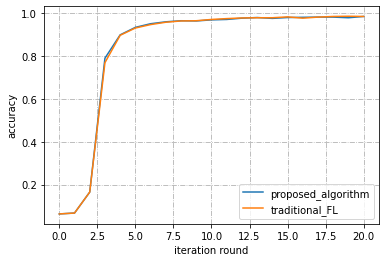

In [ ]:
bad_user_number=0
all_user_number=good_user_number+bad_user_number

tf.reset_default_graph()
global_sess.close()
tf.set_random_seed(2)
global_sess=tf.Session()

with tf.variable_scope("requester"):
  requester_FL=FL("initial_model",global_sess,requester_data,requester_label,isCommittee=True)

all_user_FL=[]
for i in range(good_user_number):
  name="u"+str(i)
  with tf.variable_scope(name):
    data=all_user_data[i]
    label=all_user_label[i]

    all_user_FL.append(FL(name,global_sess,data,label,isCommittee=True))

for j in range(bad_user_number):
  name="bad_u"+str(j)
  with tf.variable_scope(name):
    all_user_FL.append(FL(name,global_sess,isCommittee=True,isBad=True))

with tf.variable_scope("global_model"):
  global_model=FL("global_model",global_sess)

global_sess.run(tf.global_variables_initializer())

_,_,validate_global_model_accuracy_1=proposed_algorithm_2()
plot_compare_algoritms(validate_global_model_accuracy_1,"proposed_algorithm",validate_global_model_accuracy_2,"traditional_FL","haha.pdf")

### bad_number=2 & traditinal_FL 

In [ ]:
bad_user_number=2
all_user_number=good_user_number+bad_user_number

tf.reset_default_graph()
global_sess.close()
tf.set_random_seed(2)
global_sess=tf.Session()


with tf.variable_scope("requester"):
  requester_FL=FL("initial_model",global_sess,requester_data,requester_label,isCommittee=True)

all_user_FL=[]
for i in range(good_user_number):
  name="u"+str(i)
  with tf.variable_scope(name):
    data=all_user_data[i]
    label=all_user_label[i]
    all_user_FL.append(FL(name,global_sess,data,label,isCommittee=True))


for j in range(bad_user_number):
  name="bad_u"+str(j)
  with tf.variable_scope(name):
    all_user_FL.append(FL(name,global_sess,isCommittee=True,isBad=True))

with tf.variable_scope("global_model"):
  global_model=FL("global_model",global_sess)


global_sess.run(tf.global_variables_initializer())
validate_global_model_accuracy_4=traditional_FL()

accuracy of pretrain:0.10999999940395355
0.06300000008195639
[ 0.0324733   0.04973522 -0.05291686  0.03745222  0.00895618]
[ 0.03247407  0.04972567 -0.05289091  0.03741733  0.00897409]
[ 0.03245089  0.04971856 -0.05291888  0.03743902  0.00895413]
[ 0.03247705  0.0497409  -0.05289959  0.03741641  0.00895846]
[ 0.03246212  0.04976742 -0.05291404  0.03743483  0.00897237]
[ 0.03245788  0.04976622 -0.05290047  0.03741799  0.00897388]
[ 0.03245692  0.04974793 -0.05293828  0.03743866  0.00897798]
[ 0.03243637  0.04971077 -0.05291852  0.03742341  0.00893782]
[ 0.03248084  0.0497156  -0.0529021   0.03743192  0.00895782]
[ 0.03247872  0.04972914 -0.05290418  0.03741119  0.00896903]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
0:  0.06599999982863664
[ 0.02737275  0.04292098 -0.04570967  0.0350602   0.01042251]
[ 0.02752863  0.04276421 -0.04540974  0.0345967   0.01077853]
[ 0.02704241  0.04300079 -0.0455738   0.03475955  0.00994633]
[ 0.02722827  0.04316515 -0.04522085  0.0342591   0.00995425]
[ 0.0270537  

### bad_number=2 & proposed_algorithm 

accuracy of pretrain:0.10999999940395355
0.06300000008195639
处理前 global_model_score: [0.06104477581137155, 0.06029850717133553, 0.05970149237050941, 0.0652238805291813, 0.06552238804079705, 0.06044776081594071, 0.06567164165760155, 0.06268656709745753, 0.0634328355150881, 0.05716417893878562, 0.999999, 0.999999]
处理后 global_model_score: [0.06104477581137155, 0.06029850717133553, 0.05970149237050941, 0.0652238805291813, 0.06552238804079705, 0.06044776081594071, 0.06567164165760155, 0.06268656709745753, 0.0634328355150881, 0.05716417893878562]
global_model_score: 0.06211940279480684
[ 0.0324733   0.04973522 -0.05291686  0.03745222  0.00895618]
[ 0.03247405  0.04972567 -0.05289087  0.03741741  0.00897407]
[ 0.03245089  0.04971856 -0.05291888  0.03743902  0.00895413]
[ 0.03247705  0.0497409  -0.05289959  0.03741641  0.00895846]
[ 0.03246212  0.04976742 -0.05291404  0.03743483  0.00897237]
[ 0.03245788  0.04976622 -0.05290047  0.03741799  0.00897388]
[ 0.03245692  0.04974793 -0.05293828  0.0

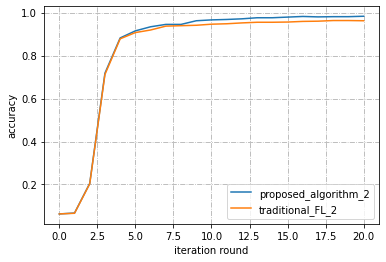

In [ ]:
bad_user_number=2
all_user_number=good_user_number+bad_user_number

tf.reset_default_graph()
global_sess.close()
tf.set_random_seed(2)
global_sess=tf.Session()



with tf.variable_scope("requester"):
  requester_FL=FL("initial_model",global_sess,requester_data,requester_label,isCommittee=True)

all_user_FL=[]
for i in range(good_user_number):
  name="u"+str(i)
  with tf.variable_scope(name):
    data=all_user_data[i]
    label=all_user_label[i]
    all_user_FL.append(FL(name,global_sess,data,label,isCommittee=True))


for j in range(bad_user_number):
  name="bad_u"+str(j)
  with tf.variable_scope(name):
    all_user_FL.append(FL(name,global_sess,isCommittee=True,isBad=True))

with tf.variable_scope("global_model"):
  global_model=FL("global_model",global_sess)


global_sess.run(tf.global_variables_initializer())
_,_,validate_global_model_accuracy_3=proposed_algorithm_2()
plot_compare_algoritms(validate_global_model_accuracy_3,"proposed_algorithm_2",validate_global_model_accuracy_4,"traditional_FL_2","haha_1.pdf")

### bad_number=5 & traditional_FL

In [ ]:
bad_user_number=5
all_user_number=good_user_number+bad_user_number

tf.reset_default_graph()
global_sess.close()
tf.set_random_seed(2)
global_sess=tf.Session()


with tf.variable_scope("requester"):
  requester_FL=FL("initial_model",global_sess,requester_data,requester_label,isCommittee=True)

all_user_FL=[]
for i in range(good_user_number):
  name="u"+str(i)
  with tf.variable_scope(name):
    data=all_user_data[i]
    label=all_user_label[i]
    all_user_FL.append(FL(name,global_sess,data,label,lr=0.0005,isCommittee=True))


for j in range(bad_user_number):
  name="bad_u"+str(j)
  with tf.variable_scope(name):
    all_user_FL.append(FL(name,global_sess,isCommittee=True,isBad=True))

with tf.variable_scope("global_model"):
  global_model=FL("global_model",global_sess)


global_sess.run(tf.global_variables_initializer())
validate_global_model_accuracy_8=traditional_FL()

accuracy of pretrain:0.10999999940395355
0.06300000008195639
[ 0.0324733   0.04973522 -0.05291686  0.03745222  0.00895618]
[ 0.03247407  0.04972567 -0.05289091  0.03741733  0.00897409]
[ 0.03245089  0.04971856 -0.05291888  0.03743902  0.00895413]
[ 0.03247705  0.0497409  -0.05289959  0.03741641  0.00895846]
[ 0.03246212  0.04976742 -0.05291404  0.03743483  0.00897237]
[ 0.03245788  0.04976622 -0.05290047  0.03741799  0.00897388]
[ 0.03245692  0.04974793 -0.05293828  0.03743866  0.00897798]
[ 0.03243637  0.04971077 -0.05291852  0.03742341  0.00893782]
[ 0.03248084  0.0497156  -0.0529021   0.03743192  0.00895782]
[ 0.03247872  0.04972914 -0.05290418  0.03741119  0.00896903]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
0:  0.0650000000372529
[ 0.02198923  0.03353079 -0.03589224  0.02667925  0.00733694]
[ 0.02201272  0.03360347 -0.03571635  0.02642227  0.00744327]
[ 0.02179522  0.03353405 -0.03579901  0.02661637  0.00716884]
[ 0.02209912  0.03376523 

### bad_number=5 & proposed_algorithm

accuracy of pretrain:0.10999999940395355
0.06300000008195639
处理前 global_model_score: [0.06104477581137155, 0.06029850717133553, 0.05970149237050941, 0.0652238805291813, 0.06552238804079705, 0.06044776081594071, 0.06567164165760155, 0.06268656709745753, 0.0634328355150881, 0.05716417893878562, 0.999999, 0.999999, 0.999999, 0.999999, 0.999999]
处理后 global_model_score: [0.06104477581137155, 0.06029850717133553, 0.05970149237050941, 0.0652238805291813, 0.06552238804079705, 0.06044776081594071, 0.06567164165760155, 0.06268656709745753, 0.0634328355150881, 0.05716417893878562]
global_model_score: 0.06211940279480684
[ 0.0324733   0.04973522 -0.05291686  0.03745222  0.00895618]
[ 0.03247405  0.04972567 -0.05289087  0.03741741  0.00897407]
[ 0.03245089  0.04971856 -0.05291888  0.03743902  0.00895413]
[ 0.03247705  0.0497409  -0.05289959  0.03741641  0.00895846]
[ 0.03246212  0.04976742 -0.05291404  0.03743483  0.00897237]
[ 0.03245788  0.04976622 -0.05290047  0.03741799  0.00897388]
[ 0.0324569

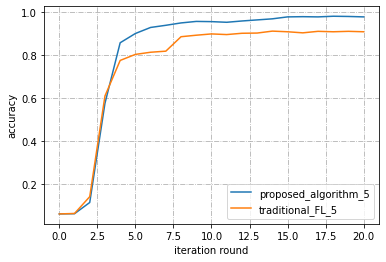

In [ ]:
bad_user_number=5
all_user_number=good_user_number+bad_user_number

tf.reset_default_graph()
global_sess.close()
tf.set_random_seed(2)
global_sess=tf.Session()

with tf.variable_scope("requester"):
  requester_FL=FL("initial_model",global_sess,requester_data,requester_label,isCommittee=True)

all_user_FL=[]
for i in range(good_user_number):
  name="u"+str(i)
  with tf.variable_scope(name):
    data=all_user_data[i]
    label=all_user_label[i]
    all_user_FL.append(FL(name,global_sess,data,label,lr=0.0005,isCommittee=True))


for j in range(bad_user_number):
  name="bad_u"+str(j)
  with tf.variable_scope(name):
    all_user_FL.append(FL(name,global_sess,isCommittee=True,isBad=True))

with tf.variable_scope("global_model"):
  global_model=FL("global_model",global_sess)


global_sess.run(tf.global_variables_initializer())
_,_,validate_global_model_accuracy_7=proposed_algorithm_2()
plot_compare_algoritms(validate_global_model_accuracy_7,"proposed_algorithm_5",validate_global_model_accuracy_8,"traditional_FL_5","haha_2.pdf")


### 画图 & 保存原始数据

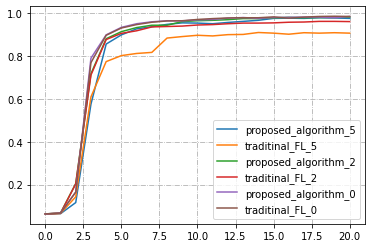

In [ ]:
plt.plot(validate_global_model_accuracy_7,label="proposed_algorithm_5")
plt.plot(validate_global_model_accuracy_8,label="traditinal_FL_5")
plt.plot(validate_global_model_accuracy_3,label="proposed_algorithm_2")
plt.plot(validate_global_model_accuracy_4,label="traditinal_FL_2")
plt.plot(validate_global_model_accuracy_1,label="proposed_algorithm_0")
plt.plot(validate_global_model_accuracy_2,label="traditinal_FL_0")

pd.DataFrame(validate_global_model_accuracy_7).to_csv("/iid/proposed_algorithm_5.csv")
pd.DataFrame(validate_global_model_accuracy_8).to_csv("/iid/traditinal_FL_5.csv")
pd.DataFrame(validate_global_model_accuracy_3).to_csv("/iid/proposed_algorithm_2.csv")
pd.DataFrame(validate_global_model_accuracy_4).to_csv("/iid/traditinal_FL_2.csv")
pd.DataFrame(validate_global_model_accuracy_1).to_csv("/iid/proposed_algorithm_0.csv")
pd.DataFrame(validate_global_model_accuracy_2).to_csv("/iid/traditinal_FL_0.csv")

plt.legend(loc="best")
plt.grid(linestyle='-.')
plt.savefig("bad_model_haha.pdf",format='pdf')  
plt.show()